In [21]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
sys.path.append('../pywrdrb/')

sys.path.append('./')
sys.path.append('../')

from pywrdrb.plotting.plotting_functions import *
from pywrdrb.plotting.styles import *
from pywrdrb.utils.lists import reservoir_list, reservoir_list_nyc, majorflow_list, majorflow_list_figs, reservoir_link_pairs
from pywrdrb.utils.constants import cms_to_mgd, cm_to_mg, cfs_to_mgd
from pywrdrb.utils.directories import input_dir, output_dir, fig_dir
from pywrdrb.post.get_results import get_base_results, get_pywr_results
from pywrdrb.plotting.plotting_functions import new_plot_NYC_release_components_combined
rerun_all = True

## Load data    
# Load Pywr-DRB simulation models
print(f'Retrieving simulation data.')
pywr_models = ['nhmv10', 'nwmv21', 'nhmv10_withObsScaled', 'nwmv21_withObsScaled']

reservoir_downstream_gages = {}
major_flows = {}
storages = {}
reservoir_releases = {}
ffmp_levels = {}
ffmp_level_boundaries = {}
inflows = {}
nyc_release_components = {}
ibt_demands = {}
ibt_diversions = {}
catchment_consumptions = {}
mrf_targets = {}
downstream_release_targets = {}
lower_basin_mrf_contributions = {}

datetime_index = None
for model in pywr_models:
    print(f'pywr_{model}')
    reservoir_downstream_gages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, results_set='reservoir_downstream_gage', datetime_index=datetime_index)
    reservoir_downstream_gages[f'pywr_{model}']['NYCAgg'] = reservoir_downstream_gages[f'pywr_{model}'][reservoir_list_nyc].sum(axis=1)
    major_flows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, results_set='major_flow', datetime_index=datetime_index)
    storages[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, results_set='res_storage', datetime_index=datetime_index)
    reservoir_releases[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, results_set='res_release', datetime_index=datetime_index)
    ffmp_levels[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, results_set='res_level', datetime_index=datetime_index)
    inflows[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'inflow', datetime_index=datetime_index)
    nyc_release_components[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'nyc_release_components', datetime_index=datetime_index)
    ibt_demands[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'ibt_demands', datetime_index=datetime_index)
    ibt_diversions[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'ibt_diversions', datetime_index=datetime_index)
    catchment_consumptions[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'catchment_consumption', datetime_index=datetime_index)
    mrf_targets[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'mrf_targets', datetime_index=datetime_index)
    downstream_release_targets[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'downstream_release_target', datetime_index=datetime_index)
    lower_basin_mrf_contributions[f'pywr_{model}'], datetime_index = get_pywr_results(output_dir, model, 'lower_basin_mrf_contributions', datetime_index=datetime_index)

ffmp_level_boundaries, datetime_index = get_pywr_results(output_dir, model, results_set='ffmp_level_boundaries', datetime_index=datetime_index)

pywr_models = [f'pywr_{m}' for m in pywr_models]

### Load base (non-pywr) models
base_models = ['obs', 'nhmv10', 'nwmv21', 'nhmv10_withObsScaled', 'nwmv21_withObsScaled']

datetime_index = list(reservoir_downstream_gages.values())[0].index
for model in base_models:
    print(model)
    reservoir_downstream_gages[model], datetime_index = get_base_results(input_dir, model, results_set='reservoir_downstream_gage', datetime_index=datetime_index)
    reservoir_downstream_gages[model]['NYCAgg'] = reservoir_downstream_gages[model][reservoir_list_nyc].sum(axis=1)
    major_flows[model], datetime_index = get_base_results(input_dir, model, results_set='major_flow', datetime_index=datetime_index)

### different time periods for different type of figures.
start_date_obs = pd.to_datetime('2008-01-01')   ### comparison to observed record, error metrics
end_date_obs = pd.to_datetime('2017-01-01')
start_date_short_obs = pd.to_datetime('2011-01-01')   ### comparison to observed record, error metrics
end_date_short_obs = pd.to_datetime('2013-01-01')
start_date_full = pd.to_datetime('1984-01-01')  ### full NHM/NWM time series
end_date_full = pd.to_datetime('2017-01-01')
start_date_medium_preobs = pd.to_datetime('1990-01-01') ### 10-year period in pre-observed record for zoomed dynamics
end_date_medium_preobs = pd.to_datetime('2000-01-01')
start_date_short_preobs = pd.to_datetime('1993-01-01') ### short 2-year period pre observed record for zoomed dynamics
end_date_short_preobs = pd.to_datetime('1996-01-01')


Retrieving simulation data.
pywr_nhmv10
pywr_nwmv21
pywr_nhmv10_withObsScaled
pywr_nwmv21_withObsScaled
obs
nhmv10
nwmv21
nhmv10_withObsScaled
nwmv21_withObsScaled


In [46]:
### function to return subset of dates for timeseries data
def subset_timeseries(timeseries, start_date, end_date, end_inclusive=True):
    data = timeseries.copy()
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
    if not end_inclusive:
        end_date = end_date - dt.timedelta(days=1)

    if start_date is not None:
        data = data.loc[start_date:]
    if end_date is not None:
        data = data.loc[:end_date]
    return data





def new_plot_NYC_release_components_combined(nyc_release_components,
                                             lower_basin_mrf_contributions, 
                                             reservoir_releases, major_flows, inflows, diversions,
                                         consumptions, model, node, start_date = None, end_date = None,
                                         use_proportional=False, use_log=False, fig_dir=fig_dir):
    fig, axs = plt.subplots(2,1,figsize=(8,5))

    ### subfig a: first split up NYC releases into components
    release_total = subset_timeseries(reservoir_releases[model][reservoir_list_nyc], start_date, end_date).sum(axis=1)
    x = release_total.index
    if use_proportional:
        ax2 = axs[0]
        ax2.plot(release_total, color='k', lw=1)
        ax2.set_xlim([x[0], x[-1]])
        ax = ax2.twinx()
        ax.set_ylim([0,100])

        if use_log:
            ax2.semilogy()

    else:
        ax = axs[0]
        ax.plot(release_total, color='k', lw=1)
        ax.set_xlim([x[0], x[-1]])
        if use_log:
            ax.semilogy()

    ### colorbrewer brown/teal palette https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=4
    colors = ['#01665e', '#35978f', '#80cdc1', '#c7eae5', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a']
    alpha = 1


    release_components_full = subset_timeseries(nyc_release_components[model], start_date, end_date)
    release_types = ['mrf_target_individual', 'mrf_montagueTrenton', 'flood_release', 'spill']
    release_components = pd.DataFrame({release_type: release_components_full[[c for c in release_components_full.columns if release_type in c]].sum(axis=1) for release_type in release_types})

    lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions[model], start_date, end_date)
    lower_basin_mrf_contributions.columns = [c.split('_')[-1] for c in lower_basin_mrf_contributions.columns]
    
    if use_proportional:
        release_components = release_components.divide(release_total, axis=0) * 100

    y1 = 0
    y2 = y1 + release_components[f'mrf_montagueTrenton'].values
    y3 = y2 + release_components[f'mrf_target_individual'].values
    y4 = y3 + release_components[f'flood_release'].values
    y5 = y4 + release_components[f'spill'].values
    ax.fill_between(x, y4, y5, label='NYC Spill', color=colors[0], alpha=alpha)
    ax.fill_between(x, y3, y4, label='NYC FFMP Flood', color=colors[1], alpha=alpha)
    ax.fill_between(x, y2, y3, label='NYC FFMP Individual', color=colors[2], alpha=alpha)
    ax.fill_between(x, y1, y2, label='NYC FFMP Downstream', color=colors[3], alpha=alpha)

    if use_proportional:
        ax2.set_ylabel('Total Release (MGD)')
        ax.set_ylabel('Release Contribution (%)')
    else:
        ax.set_ylabel('Total Release (MGD)')


    if use_proportional:
        ax.set_zorder(1)
        ax2.set_zorder(2)
        ax2.patch.set_visible(False)

    ### subfig b: split up trenton flow into components

    # Get total sim and obs flow
    total_sim_node_flow = subset_timeseries(major_flows[model][node], start_date, end_date)

    ### for Trenton, we use "Trenton Equivalent Flow" 
    # add NJ diversion to simulated flow
    # add blueMarsh MRF contribution (not connected in simulated but is included in "equivelent flow")
    if node == 'delTrenton':
        nj_diversion = subset_timeseries(diversions[model]['delivery_nj'], start_date, end_date)
        total_sim_node_flow += nj_diversion
        
        blueMarsh_mrf_contribution = subset_timeseries(lower_basin_mrf_contributions['blueMarsh'], start_date, end_date)
        total_sim_node_flow += blueMarsh_mrf_contribution
        
    if use_proportional:
        ax2 = axs[1]
        ax2.plot(total_sim_node_flow, color='k', lw=1)
        ax = ax2.twinx()
        ax.set_ylim([0,100])
        ax.set_xlim(total_sim_node_flow.index[0], total_sim_node_flow.index[-1])
        if use_log:
            ax2.semilogy()

        ax2.set_ylabel('Total Flow (MGD)')
        ax.set_ylabel('Flow Contribution (%)')
    else:
        ax = axs[1]
        ax.plot(total_sim_node_flow, color='k', lw=1)
        ax.set_ylabel('Total Release (MGD)')


    # Get contributing flows
    contributing = upstream_nodes_dict[node]
    non_nyc_reservoirs = [i for i in contributing if (i in reservoir_list) and (i not in reservoir_list_nyc)]
    
    non_nyc_release_contributions = reservoir_releases[model][non_nyc_reservoirs]         
        
    use_inflows = [i for i in contributing if (i in majorflow_list)]
    if node == 'delMontague':
        use_inflows.append('delMontague')
    inflow_contributions = inflows[model][use_inflows] - consumptions[model][use_inflows]
    mrf_target_individuals = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'mrf_target_individual' in c]]
    mrf_target_individuals.columns = [c.rsplit('_',1)[1] for c in mrf_target_individuals.columns]
    mrf_montagueTrentons = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'mrf_montagueTrenton' in c]]
    mrf_montagueTrentons.columns = [c.rsplit('_',1)[1] for c in mrf_montagueTrentons.columns]
    flood_releases = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'flood_release' in c]]
    flood_releases.columns = [c.rsplit('_',1)[1] for c in flood_releases.columns]
    spills = nyc_release_components[model][[c for c in nyc_release_components[model].columns if 'spill' in c]]
    spills.columns = [c.rsplit('_',1)[1] for c in spills.columns]


    # Impose lag
    for c in upstream_nodes_dict[node][::-1]:
        if c in inflow_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                inflow_contributions[c].iloc[lag:] = inflow_contributions[c].iloc[:-lag]
        elif c in non_nyc_release_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                non_nyc_release_contributions[c].iloc[lag:] = non_nyc_release_contributions[c].iloc[:-lag]
        elif c in mrf_target_individuals.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                mrf_target_individuals[c].iloc[lag:] = mrf_target_individuals[c].iloc[:-lag]
                mrf_montagueTrentons[c].iloc[lag:] = mrf_montagueTrentons[c].iloc[:-lag]
                flood_releases[c].iloc[lag:] = flood_releases[c].iloc[:-lag]
                spills[c].iloc[lag:] = spills[c].iloc[:-lag]
        elif c in lower_basin_mrf_contributions.columns:
            lag = downstream_node_lags[c]
            downstream_node = immediate_downstream_nodes_dict[c]
            while downstream_node != node:
                lag += downstream_node_lags[downstream_node]
                downstream_node = immediate_downstream_nodes_dict[downstream_node]
            if lag > 0:
                lower_basin_mrf_contributions[c].iloc[lag:] = lower_basin_mrf_contributions[c].iloc[:-lag]
                


    inflow_contributions = subset_timeseries(inflow_contributions, start_date, end_date).sum(axis=1)
    non_nyc_release_contributions = subset_timeseries(non_nyc_release_contributions, start_date, end_date).sum(axis=1)
    mrf_target_individuals = subset_timeseries(mrf_target_individuals, start_date, end_date).sum(axis=1)
    mrf_montagueTrentons = subset_timeseries(mrf_montagueTrentons, start_date, end_date).sum(axis=1)
    flood_releases = subset_timeseries(flood_releases, start_date, end_date).sum(axis=1)
    spills = subset_timeseries(spills, start_date, end_date).sum(axis=1)
    lower_basin_mrf_contributions = subset_timeseries(lower_basin_mrf_contributions, start_date, end_date).sum(axis=1)
    
    if use_proportional:
        inflow_contributions = inflow_contributions.divide(total_sim_node_flow) * 100
        non_nyc_release_contributions = non_nyc_release_contributions.divide(total_sim_node_flow) * 100
        mrf_target_individuals = mrf_target_individuals.divide(total_sim_node_flow) * 100
        mrf_montagueTrentons = mrf_montagueTrentons.divide(total_sim_node_flow) * 100
        flood_releases = flood_releases.divide(total_sim_node_flow) * 100
        spills = spills.divide(total_sim_node_flow) * 100
        lower_basin_mrf_contributions = lower_basin_mrf_contributions.divide(total_sim_node_flow) * 100

    y1 = 0
    y2 = y1 + inflow_contributions
    y3 = y2 + non_nyc_release_contributions
    y3_5 = y3 + lower_basin_mrf_contributions
    y4 = y3_5 + mrf_montagueTrentons
    y5 = y4 + mrf_target_individuals
    y6 = y5 + flood_releases
    y7 = y6 + spills
    ax.fill_between(x, y6, y7, label='NYC Spill', color=colors[0], alpha=alpha)
    ax.fill_between(x, y5, y6, label='NYC FFMP Flood', color=colors[1], alpha=alpha)
    ax.fill_between(x, y4, y5, label='NYC FFMP Individual', color=colors[2], alpha=alpha)
    ax.fill_between(x, y3_5, y4, label='NYC FFMP Downstream', color=colors[3], alpha=alpha)
    ax.fill_between(x, y3, y3_5, label = 'Lower Basin FFMP', color = 'purple', alpha=alpha)
    ax.fill_between(x, y2, y3, label='Non-NYC Release', color=colors[5], alpha=alpha)
    ax.fill_between(x, y1, y2, label='Uncontrolled Flow', color=colors[4], alpha=alpha)

    ax.legend(frameon=False, loc='center', bbox_to_anchor=(0.5, -0.3), ncols=3)

    if use_proportional:
        ax.set_zorder(1)
        ax2.set_zorder(2)
        ax2.patch.set_visible(False)



    plt.savefig(f'{fig_dir}NYC_release_components_combined_{model}_{node}_' + \
                f'{release_total.index.year[0]}_{release_total.index.year[-1]}.png',
                bbox_inches='tight', dpi=500)

C:\Users\tjame\AppData\Local\Temp\ipykernel_14468\3255690877.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nyc_release_contributions[c].iloc[lag:] = non_nyc_release_contributions[c].iloc[:-lag]
C:\Users\tjame\AppData\Local\Temp\ipykernel_14468\3255690877.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrf_target_individuals[c].iloc[lag:] = mrf_target_individuals[c].iloc[:-lag]
C:\Users\tjame\AppData\Local\Temp\ipykernel_14468\3255690877.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

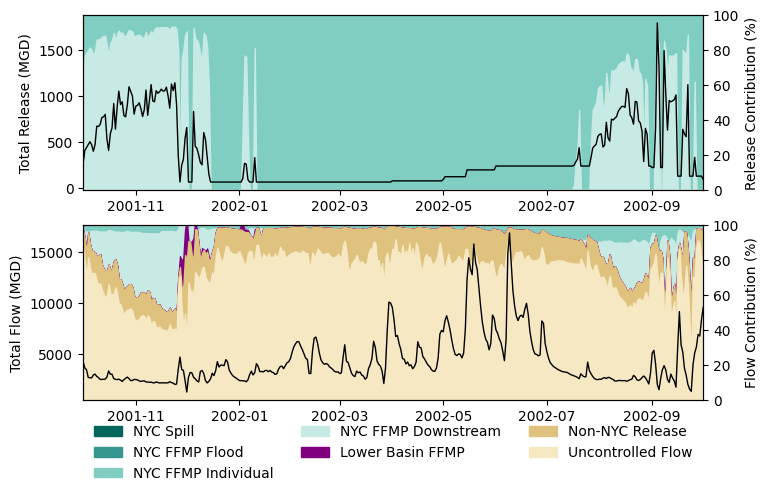

In [50]:
test_model = 'pywr_nhmv10_withObsScaled'

new_plot_NYC_release_components_combined(nyc_release_components, lower_basin_mrf_contributions, reservoir_releases, 
                                         major_flows, inflows, ibt_diversions, catchment_consumptions, 
                                         test_model, 
                                         'delTrenton',
                                         start_date= pd.to_datetime('2001-10-01'), 
                                         end_date=  pd.to_datetime('2002-10-01'), 
                                         use_proportional=True)
 

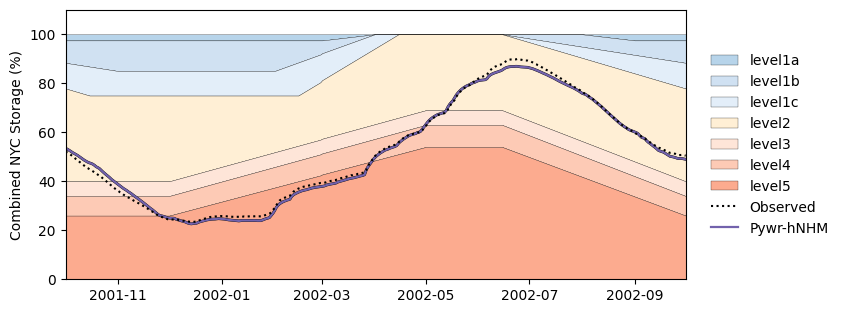

In [51]:
plot_combined_nyc_storage_new(storages, ffmp_level_boundaries, [test_model], colordict = model_colors_diagnostics_paper3,
                                         start_date= pd.to_datetime('2001-10-01'), 
                                         end_date=  pd.to_datetime('2002-10-01'), 
                                      fig_dir=fig_dir)

In [5]:
lower_basin_mrf_contributions['pywr_nwmv21_withObsScaled'].loc['2016-01-01':].sum()

mrf_montagueTrenton_beltzvilleCombined    2518.673395
mrf_montagueTrenton_blueMarsh                0.000000
mrf_montagueTrenton_nockamixon               0.000000
dtype: float64

In [6]:
lower_elevations= pd.read_csv(f'{input_dir}historic_reservoir_ops/lower_basin_reservoir_elevation.csv', 
                            index_col=0, parse_dates=True)
lower_storages = pd.DataFrame(index=lower_elevations.index, columns=lower_elevations.columns)

storage_curves = {}
for res in ['blueMarsh', 'beltzvilleCombined', 'fewalter']:
    storage_curves[res]= pd.read_csv(f'{input_dir}historic_reservoir_ops/{res}_elevation_storage_curve.csv', sep=',')

for reservoir in lower_elevations.columns:
    curve= storage_curves[reservoir]
    lb_elev= lower_elevations.loc[:, reservoir]
    lb_stor = np.interp(lb_elev.dropna().values, curve['Elevation (ft)'],
                        curve['BG'])
    lb_stor = lb_stor*1000
    lb_stor = pd.Series(lb_stor, index=lb_elev.dropna().index)
    lower_storages.loc[:, reservoir] = lb_stor
lower_storages

C:\Users\tjame\AppData\Local\Temp\ipykernel_8044\3881034711.py:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  lower_storages.loc[:, reservoir] = lb_stor


,beltzvilleCombined,blueMarsh,fewalter
datetime,,,
2009-10-15,13987.0,6599.6,NaN
2009-10-16,13993.1,6520.0,NaN
2009-10-17,13993.1,6455.6,NaN
2009-10-18,13990.0,6422.0,NaN
2009-10-19,13987.0,6374.4,NaN
...,...,...,...
2023-07-07,13993.1,6631.6,6787.6
2023-07-08,13999.3,6666.8,6758.7
2023-07-09,14117.1,6766.0,7105.2


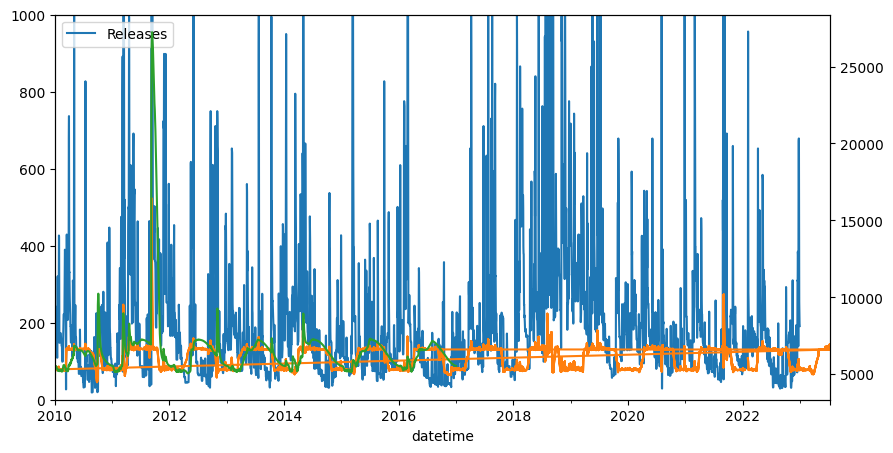

In [7]:
fig,ax = plt.subplots(figsize=(10,5))
reservoir = 'blueMarsh'
sd = '2010-01-01'
reservoir_downstream_gages['obs'].loc[sd:, reservoir].plot(ax=ax, label='Releases', legend=True)

# storage with secondary y-axis
lower_storages.loc[sd:, reservoir].plot(ax=ax, secondary_y=True, label='Storage', legend=True)
storages['pywr_nwmv21_withObsScaled'].loc[sd:, reservoir].plot(ax=ax, secondary_y=True, label='Storage', legend=True)
ax.legend()
ax.set_ylim(0,1000)
plt.show()


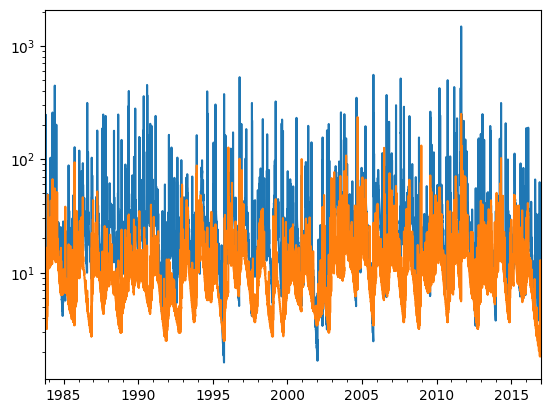

In [14]:
# reservoir_releases['pywr_nwmv21']['nockamixon'].plot()
# plt.ylim(0,100)
# catchment_consumptions['pywr_nwmv21_withObsScaled']['nockamixon'].plot()
# inflows['pywr_nhmv10_withObsScaled']['nockamixon'].mean()
# storages['pywr_nhmv10_withObsScaled']['nockamixon'].plot()

fig, ax = plt.subplots()
inflows['pywr_nhmv10_withObsScaled']['nockamixon'].plot(ax=ax)
inflows['pywr_nwmv21_withObsScaled']['nockamixon'].plot(ax=ax)
plt.yscale('log')

<Axes: >

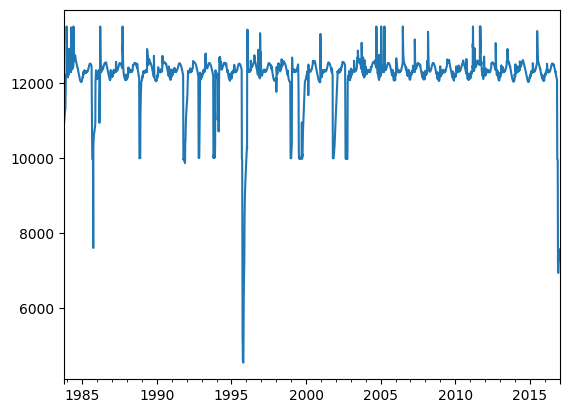

In [43]:
S = storages['pywr_nwmv21']['beltzvilleCombined']
S_p = S / S.max()
fig,ax = plt.subplots()
S.plot(ax=ax)
# lower_storages['beltzvilleCombined'].plot(ax=ax)

(4000.0, 10000.0)

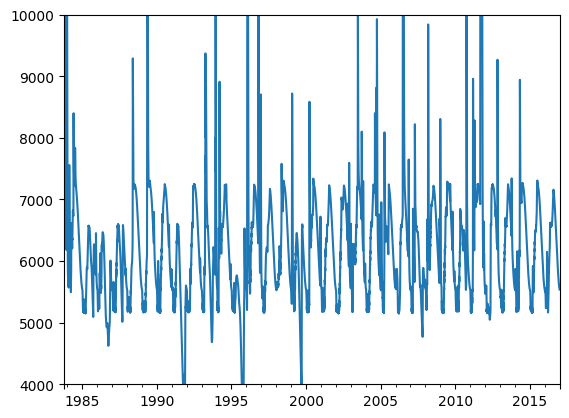

ValueError: x and y must have same first dimension, but have shapes (365,) and (92,)

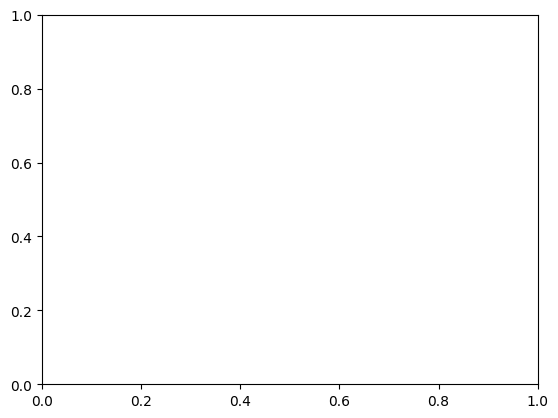

In [53]:
# Plot both sim and obs storage with 
# each year individually overlaid
reservoir = 'blueMarsh'
model = 'pywr_nwmv21_withObsScaled'
fig,ax = plt.subplots()

# get obs years
obs_years = lower_storages.index.year.unique()
sim_years = storages[model].index.year.unique()
xs = np.arange(0,365)
for s_yr in sim_years:
    S = storages[model]
    S = S.loc[S.index.year==s_yr, reservoir]
    ys = S.values

    ax.plot(xs,ys, color='blue', alpha=0.5)
for o_yr in obs_years:
    S = lower_storages
    S = S.loc[S.index.year==o_yr, reservoir]

    ys = S

    
    ax.plot(xs,ys, color='red', alpha=0.5)
plt.show()


<Axes: >

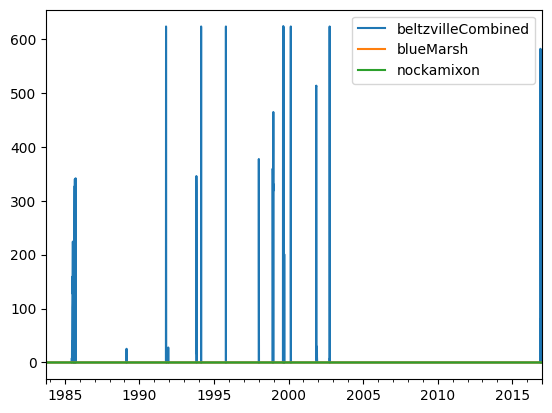

In [36]:
lower_basin_mrf_contributions['pywr_nwmv21_withObsScaled'].plot()

In [45]:
S

datetime
2009-10-15    6599.6
2009-10-16    6520.0
2009-10-17    6455.6
2009-10-18    6422.0
2009-10-19    6374.4
               ...  
2009-12-27    5609.9
2009-12-28    5731.4
2009-12-29    5609.9
2009-12-30    5425.0
2009-12-31    5285.0
Name: blueMarsh, Length: 443, dtype: float64

<Axes: xlabel='datetime'>

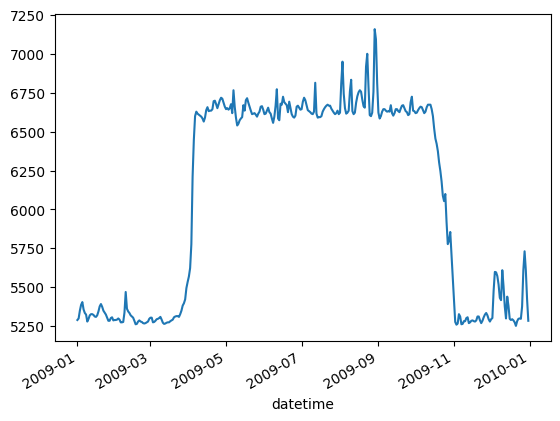

In [46]:
S.plot()

In [47]:
len(S.index.unique())

365